1. Построить модель градиентного бустинга для классификации числа страховых случаев (см. в конце ноутбука).
  - Можно предобработать исходные данные, добавив дополнительные фичи. 
  - Также можно использовать различные методы для подбора гиперпараметров.
2. Оценить результаты построенного классификатора, выявить возможные проблемы.
3. Сравнить результаты с полученным на занятии результатом с использованием Пуассоновской регрессии.
4. Проанализировать результаты, предложить способы решения обнаруженных проблем и/или попробовать его улучшить.

In [1]:
#!pip install hyperopt
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin
from sklearn.metrics import classification_report

def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [2]:
df = pd.read_csv('~/Yandex.Disk/geekbrains/Python/MLInBusines/lesson_6/freMPL-R.csv', low_memory=False)

In [3]:
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Exposure           115155 non-null  float64
 1   LicAge             115155 non-null  int64  
 2   RecordBeg          115155 non-null  object 
 3   RecordEnd          59455 non-null   object 
 4   Gender             115155 non-null  object 
 5   MariStat           115155 non-null  object 
 6   SocioCateg         115155 non-null  object 
 7   VehUsage           115155 non-null  object 
 8   DrivAge            115155 non-null  int64  
 9   HasKmLimit         115155 non-null  int64  
 10  BonusMalus         115155 non-null  int64  
 11  ClaimAmount        115155 non-null  float64
 12  ClaimInd           115155 non-null  int64  
 13  ClaimNbResp        115155 non-null  float64
 14  ClaimNbNonResp     115155 non-null  float64
 15  ClaimNbParking     115155 non-null  float64
 16  Cl

Предобрабтка данных

In [4]:
NegClaimAmount = df.loc[df.ClaimAmount < 0, ['ClaimAmount','ClaimInd']]
print('Unique values of ClaimInd:', NegClaimAmount.ClaimInd.unique())
NegClaimAmount.head()

Unique values of ClaimInd: [0]


,ClaimAmount,ClaimInd
82,-74.206042,0
175,-1222.585196,0
177,-316.288822,0
363,-666.758610,0
375,-1201.600604,0


In [5]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

In [6]:
def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [7]:
df.Gender, GenderRef = SeriesFactorizer(df.Gender)
df.MariStat, MariStatRef = SeriesFactorizer(df.MariStat)

{0: 'Male', 1: 'Female'}
{0: 'Other', 1: 'Alone'}


In [8]:
list(df.VehUsage.unique())

['Professional', 'Private+trip to office', 'Private', 'Professional run']

In [9]:
VU_dummies = pd.get_dummies(df.VehUsage, prefix='VehUsg', drop_first=False)
VU_dummies.head()

,VehUsg_Private,VehUsg_Private+trip to office,VehUsg_Professional,VehUsg_Professional run
0,0,0,1,0
1,0,0,1,0
2,0,1,0,0
3,0,1,0,0
4,1,0,0,0


In [10]:
df['SocioCateg'] = df.SocioCateg.str.slice(0,4)

In [11]:
pd.DataFrame(df.SocioCateg.value_counts().sort_values()).rename({'SocioCateg': 'Frequency'}, axis=1)

,Frequency
CSP7,14
CSP3,1210
CSP1,2740
CSP2,3254
CSP4,7648
CSP6,24833
CSP5,75456


In [12]:
df = pd.get_dummies(df, columns=['VehUsage','SocioCateg'])

In [13]:
df = df.select_dtypes(exclude=['object'])

In [14]:
df['DrivAgeSq'] = df.DrivAge.apply(lambda x: x**2)
df.head()

,Exposure,LicAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,ClaimNbResp,...,VehUsage_Professional,VehUsage_Professional run,SocioCateg_CSP1,SocioCateg_CSP2,SocioCateg_CSP3,SocioCateg_CSP4,SocioCateg_CSP5,SocioCateg_CSP6,SocioCateg_CSP7,DrivAgeSq
0,0.083,332,0,0,46,0,50,0.0,0,0.0,...,1,0,0,0,0,0,1,0,0,2116
1,0.916,333,0,0,46,0,50,0.0,0,0.0,...,1,0,0,0,0,0,1,0,0,2116
2,0.550,173,0,0,32,0,68,0.0,0,0.0,...,0,0,0,0,0,0,1,0,0,1024
3,0.089,364,1,0,52,0,50,0.0,0,0.0,...,0,0,0,0,0,0,1,0,0,2704
4,0.233,426,0,0,57,0,50,0.0,0,0.0,...,0,0,0,0,0,0,0,1,0,3249


In [15]:
df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

In [16]:
count_claims = pd.DataFrame(df.ClaimsCount.value_counts()).rename({'ClaimsCount': 'count'}, axis=1)

In [17]:
count_claims

,count
0.0,104286
2.0,3529
1.0,3339
3.0,2310
4.0,1101
5.0,428
6.0,127
7.0,26
8.0,6
9.0,2


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 24 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Exposure                         115155 non-null  float64
 1   LicAge                           115155 non-null  int64  
 2   Gender                           115155 non-null  int64  
 3   MariStat                         115155 non-null  int64  
 4   DrivAge                          115155 non-null  int64  
 5   HasKmLimit                       115155 non-null  int64  
 6   BonusMalus                       115155 non-null  int64  
 7   ClaimAmount                      115155 non-null  float64
 8   ClaimInd                         115155 non-null  int64  
 9   OutUseNb                         115155 non-null  float64
 10  RiskArea                         115155 non-null  float64
 11  VehUsage_Private                 115155 non-null  uint8  
 12  Ve

XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде [0, num_classes]. Заменим значение 11 на 10.

In [19]:
df.loc[df['ClaimsCount'] == 11, 'ClaimsCount'] = 10

Посмотрим, сколько полисов соответствуют каждому из значений ClaimsCount, используя метод groupby. Для полученных значений также посчитаем нормированную частоту.

In [20]:
FreqCount = pd.DataFrame(df[{'Exposure', 'ClaimsCount'}].groupby('ClaimsCount').count()['Exposure'].values, 
                         columns=['Count'])
FreqCount['Freq'] = FreqCount['Count'] / FreqCount['Count'].sum()
# df[{'Exposure', 'ClaimsCount'}].groupby('ClaimsCount').count()['Exposure'].values

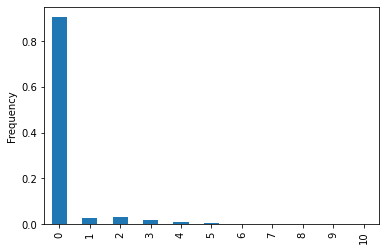

In [21]:
FreqCount.Freq.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

In [22]:
FreqCount

,Count,Freq
0,104286,0.905614
1,3339,0.028996
2,3529,0.030646
3,2310,0.020060
4,1101,0.009561
5,428,0.003717
6,127,0.001103
7,26,0.000226
8,6,0.000052
9,2,0.000017


Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец weight. Присвоим ему некоторые значения, например, можно задать 0.05 для значений ClaimsCount 0, а для остальных - 1 (Для этого можем использовать функцию np.where). Также можно попробовать какой-либо другой способ задания весов, приведенный пример не гарантирует хороших результатов.

In [23]:
df['weight'] = 0

In [24]:
weg = FreqCount['Count'] / FreqCount['Count'].sum()

In [27]:
for param in weg.index:
     df.loc[df['ClaimsCount'] == param, 'weight'] = 1 - weg[param]

Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [28]:
TARGET_NAME = 'ClaimsCount'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
x_train, x_test, y_train, y_test = train_test_split(df[BASE_FEATURE_NAMES], df[TARGET_NAME], test_size=0.3, random_state=10)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)

In [29]:
x_train['weight'].values

array([0.09438583, 0.09438583, 0.09438583, ..., 0.09438583, 0.09438583,
       0.09438583])

Далее, создадим объекты DMatrix для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр weight равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр data.

In [35]:
xgb_train = xgb.DMatrix(x_train.drop(['Exposure'], axis=1), label=y_train.values)
xgb_valid = xgb.DMatrix(x_valid.drop(['Exposure'], axis=1),  label=y_valid.values)
test_xgb_testc = xgb.DMatrix(x_test.drop(['Exposure'], axis=1), label=y_test.values)

Далее обучим нашу модель. Подбор параметров пока не делал, хотелось сначало получить хоть что-то.

In [36]:
xgb_params = dict()
xgb_params['eta'] = 0.0365253500815
xgb_params['max_depth'] = 5
xgb_params['subsample'] = 0.789639281187
xgb_params['min_child_weight'] = 3

xgb_params['gamma'] = 0.271712091643

xgb_params['colsample_bytree'] = 0.774391443402
xgb_params['colsample_bylevel'] = 0.79407015729
xgb_params['objective'] = 'multi:softmax'
xgb_params['eval_metric'] = [ 'merror', 'mlogloss']
xgb_params['num_class'] = 11

watchlist = [(xgb_train, 'train'), (xgb_valid, 'valid')]

model = xgb.train( params=xgb_params,
                      dtrain=xgb_train,
                      num_boost_round=300,
                      evals=watchlist,
                      verbose_eval=10,
                      early_stopping_rounds=50)

[0]	train-merror:0.00032	train-mlogloss:2.19856	valid-merror:0.00035	valid-mlogloss:2.19944
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 50 rounds.
[10]	train-merror:0.00007	train-mlogloss:1.23299	valid-merror:0.00012	valid-mlogloss:1.23360
[20]	train-merror:0.00007	train-mlogloss:0.80047	valid-merror:0.00012	valid-mlogloss:0.80034
[30]	train-merror:0.00007	train-mlogloss:0.53803	valid-merror:0.00012	valid-mlogloss:0.53822
[40]	train-merror:0.00007	train-mlogloss:0.36899	valid-merror:0.00012	valid-mlogloss:0.36947
[50]	train-merror:0.00007	train-mlogloss:0.25539	valid-merror:0.00012	valid-mlogloss:0.25582
[60]	train-merror:0.00007	train-mlogloss:0.17778	valid-merror:0.00012	valid-mlogloss:0.17811
[70]	train-merror:0.00007	train-mlogloss:0.12397	valid-merror:0.00012	valid-mlogloss:0.12425
[80]	train-merror:0.00007	train-mlogloss:0.08712	valid-merror:0.00012	valid-mlogloss:0.08739
[90]	train-

Посчитаем метрики accuracy и f1 на наших наборах данных, также можем визуализировать confusion matrix, например, с помощью plt.imshow(). Можно использовать предложенный ниже код.

In [32]:
xgb_freq = model

In [38]:
train_pred = model.predict(xgb_train)
train_pred

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [39]:
dfsets = [{'set': 'train', 'dmat': xgb_train, 'target': y_train},
          {'set': 'valid', 'dmat': xgb_valid, 'target': y_valid},
          {'set': 'test', 'dmat': test_xgb_testc, 'target': y_test}]
for dfset in dfsets:
    class_preds = model.predict(dfset['dmat']) - 1
    print('F1 Score on ' + str(dfset['set'])+':', f1_score(dfset['target'], class_preds, average='micro')) # Посчитаем F1 Score

F1 Score on train: 0.0
F1 Score on valid: 0.0
F1 Score on test: 0.0


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 2. 0. ... 0. 0. 0.]
[0. 2. 0. ... 0. 0. 0.]


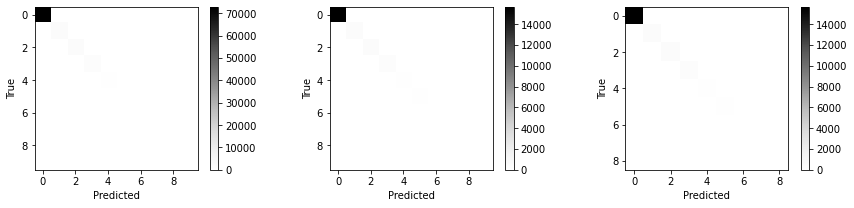

In [41]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    pred = np.round(model.predict(dfsets[i]['dmat']), 0)
    print(pred)
    print(dfsets[i]['target'].values)
    confmatrix = confusion_matrix(dfsets[i]['target'], pred)
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')
plt.show()

Как вы оцениваете качество построенной модели? Какие проблемы могут здесь присутствовать? Как можно улучшить результат?

Получилась лажа. Работаю по 12 часов. Времени на подробный разбор параметров обучения модели нет. Как буду свободнее обязательно добъю это задание до конца.